In [4]:
from pathlib import Path
from Tensorlib import tensor
import numpy as np

In [5]:
dataloc = Path("./Data/input.txt")

In [6]:
with open (dataloc, 'r', encoding='utf-8') as datafile:
    data = datafile.read()

In [7]:
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [8]:
vocab = sorted(set(data))
print(f"Vocabulary Size: {len(vocab)}")
print(f"Vocabulary: {vocab}")

Vocabulary Size: 65
Vocabulary: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [9]:
class tokenizer:
    def __init__(self, mode = 'char', max_vocab_size=None):
        self.mode = mode
        self.max_vocab_size = max_vocab_size

        self.vocab = set()
        self.stoi = {}
        self.itos = {}

    def train(self, dataset):
        if self.mode == 'char':
            self.vocab = sorted(set(dataset))
            self.stoi = {c:i for i, c in enumerate(self.vocab)}
            self.itos = {i:c for i, c in enumerate(self.vocab)}
        elif self.mode == 'word':
            self.vocab = sorted(set(dataset.split()))
            self.stoi = {s:i for i, s in enumerate(self.vocab)}
            self.itos = {i:s for i, s in enumerate(self.vocab)}
        else:
            print(f"{self.mode} not supported yet! We only support 'char' and 'word'!")

    def encode(self, text):
        if len(self.stoi) == 0:
            raise ValueError("First run train method on your data!")
        
        if self.mode == 'char':
            return [self.stoi[c] for c in text]
        elif self.mode == 'word':
            return [self.stoi[c] for c in text.split()]
        else:
            raise ValueError(f"{self.mode} not supported yet! We only support 'char' and 'word'!")

    def decode(self, ints):
        if len(self.itos) == 0:
            raise ValueError("First run train method on your data!")
        
        tlists = [self.itos[i] for i in ints]
        if self.mode == 'char':
            return "".join(tlists)
        elif self.mode == 'word':
            return " ".join(tlists)
        else: 
            raise ValueError(f"{self.mode} not supported yet! We only support 'char' and 'word'!")

In [10]:
t = tokenizer('char')
t.train(data)
encoded = t.encode(data[:100])
print(encoded)

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46, 43, 56, 6, 1, 46, 43, 39, 56, 1, 51, 43, 1, 57, 54, 43, 39, 49, 8, 0, 0, 13, 50, 50, 10, 0, 31, 54, 43, 39, 49, 6, 1, 57, 54, 43, 39, 49, 8, 0, 0, 18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 37, 53, 59]


In [11]:
decoded = t.decode(encoded)
print(decoded)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


## Word Embeddings

In [12]:
class embeddings:
    def __init__(self, vocab_size=65, embedding_dim=65):
        self.table = tensor.random(shape=(vocab_size, embedding_dim), dtype=np.float32)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

    def __call__(self, target): #Target = tensor of shape: Batch_size x context_size. eg. 16x10 for 10 words context
                                #out_matrix = np.zeros(shape=(target.shape[0], target.shape[1], self.embedding_dim))

        '''for batch_idx, i in enumerate(target):
            for token_idx, j in enumerate(i):
                out_matrix[batch_idx][token_idx] = self.table.matrix[j]'''
        #Need to vectorise this^^
        #how ? Fancy indexing!
        # 1)
        out_matrix = self.table.matrix[target.matrix] #Fancy indexing


        def _backward(grad):
            if self.table.grad is None:
                self.table.grad = np.zeros_like(self.table.matrix, dtype=np.float32)
            np.add.at(self.table.grad, target.matrix.ravel(), grad.reshape(-1, self.embedding_dim))

        out = tensor(out_matrix, _children=(self.table, ), _operation='Embedding_Lookup')
        out._backward = _backward

        return out

In [13]:
#1)
table = tensor.random(shape=(4, 2), dtype=np.float32)
table

Tensor Values = [[ 0.00610818  0.33814347]
 [ 0.03626506 -0.05562866]
 [-0.14536318  0.03480762]
 [ 0.11474843 -0.0427672 ]]

In [14]:
target = tensor([[1, 0, 3],
                [1, 1, 2],
                [2, 3, 0]])

print(f"target.shape: {target.shape}")

out_matrix = table.matrix[target.matrix] #Fancy indexing

print(f"out_matrix.shape: {out_matrix.shape}")
out_matrix

target.shape: (3, 3)
out_matrix.shape: (3, 3, 2)


array([[[ 0.03626506, -0.05562866],
        [ 0.00610818,  0.33814347],
        [ 0.11474843, -0.0427672 ]],

       [[ 0.03626506, -0.05562866],
        [ 0.03626506, -0.05562866],
        [-0.14536318,  0.03480762]],

       [[-0.14536318,  0.03480762],
        [ 0.11474843, -0.0427672 ],
        [ 0.00610818,  0.33814347]]], dtype=float32)

## Test!

In [15]:
vocab_size = 10
embed_dim = 4

# 1. Init Layer
emb = embeddings(vocab_size, embed_dim)

# 2. (Batch=2, Context=3)

input_data = np.array([[1, 4, 1], [0, 9, 2]]) 
input_tensor = tensor(input_data) 

# 3. Forward Pass
output = emb(input_tensor)
print("Output Shape:", output.matrix.shape) 
# Expected: (2, 3, 4)

# 4. Backward Pass (Fake Gradients)
fake_grad = np.ones((2, 3, 4)) # Passing a gradient of 1.0 everywhere
output._backward(fake_grad) 

print("Gradient Shape:", emb.table.grad.shape)
# Expected: (10, 4)
print("Gradient at Index 1:", emb.table.grad[1])
# Because Index '1' appears twice in the input [[1, 4, 1]...], 
# its gradient should be 1.0 + 1.0 = 2.0.

Output Shape: (2, 3, 4)
Gradient Shape: (10, 4)
Gradient at Index 1: [2. 2. 2. 2.]


In [19]:
t = tokenizer('char')
t.train(data)

print(f"Text array: {data[:40]}")
encoded = np.array(t.encode(data[:40]))
print(f"Encoded array: {encoded}")

Input_Token_Matrix = encoded.reshape(4, 10) #We are creating 10 chars sequence = Context Size. Batch size = 4
print(f"Encoded and batched matrix: {Input_Token_Matrix}")

em = embeddings()
Word_Embeddings = em(tensor(Input_Token_Matrix))
print(f"Shape of output embeddings: {Word_Embeddings.shape}")
#print(f"Embeddings from Encoded and batched matrix: {Word_Embeddings}")


Text array: First Citizen:
Before we proceed any fur
Encoded array: [18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56]
Encoded and batched matrix: [[18 47 56 57 58  1 15 47 58 47]
 [64 43 52 10  0 14 43 44 53 56]
 [43  1 61 43  1 54 56 53 41 43]
 [43 42  1 39 52 63  1 44 59 56]]
Shape of output embeddings: (4, 10, 65)


## Positional Encoding.

While the previous lookup table learns the semantic meaning of individual tokens, we need a way to let our transformer know the position of words in sentences. For doing so, we add a position vector to the word embedding. While there are other methods like Rotary Position Encoding, Relative Position Encoding etc. Here, we will be implementing the OG sinusoidal positional encoding from "Attention is All You Need".
[Notes Here](./Handwritten_Notes/)

In practice we need a method that takes number of tokens(N), and number of embeddings dimensions(D) and returns a matrix with N rows and D columns where each row represents one position whose each column value is given by a sinusoidal function with frequency determined by the previous formula. It can also take wavelength stretch as a parameter involved in that formula.

So we can create a PE class that initialises Dimension of Embeddings, the wavelength stretch and max positions/max number of tokens. It creates a 2D lookup table using these parameters. Finally, when we __call__() the class object with our number of tokens (N) < Max tokens, it simply slices from the already created lookup table similar to embeddings lookup table. This ensures the operation is fast and we dont create multiple copies.

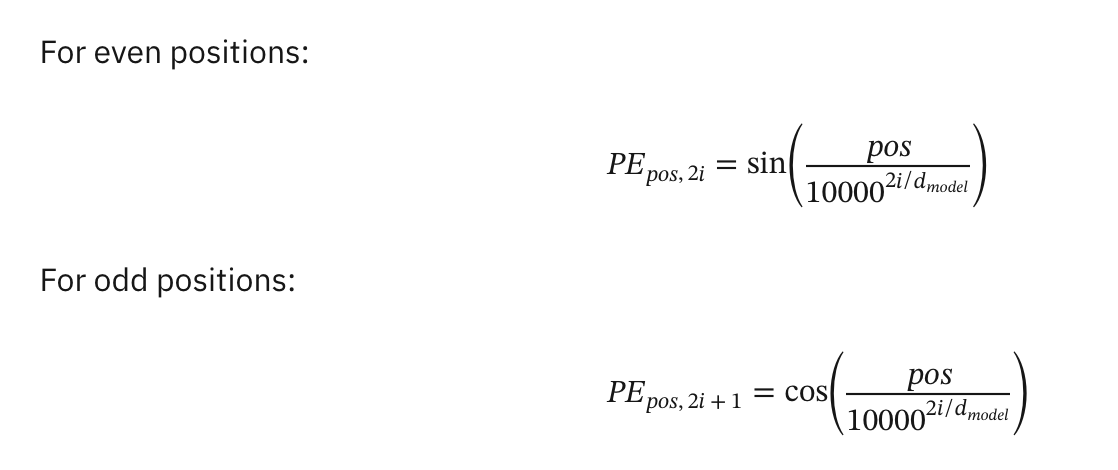

We will be using np.outer() or the outer product to get the inner term of sines and cosines. Then we will use slicing to apply sines and cosines with step = 2. 

In [ ]:
class PositionalEmbeddings:
    def __init__(self, em_dim, max_tokens, stretch=10000):
        self.em_dim = em_dim
        self.stretch = stretch
        self.max_tokens = max_tokens

        positions = np.arange(0, max_tokens, dtype=int)
        div_terms = 1/(stretch ** ((np.arange(0, em_dim, 2, dtype=np.float32))/em_dim))
        angles = np.outer(positions, div_terms)

        table = np.zeros(shape=(1, max_tokens, em_dim))
        table[:, :, 0::2] = np.sin(angles)
        table[:, :, 1::2] = np.cos(angles)

        self.table = table

    def __call__(self, embeddings: tensor):
        batch, tokens, dims = embeddings.shape
        out_matrix = self.table[:, :tokens, :]

        out = tensor(out_matrix, _children=(embeddings, ), _operation='PosEmbedding')

        #We dont need a backward pass for this operation since the positional embeddings are deterministic, not learnt.

        return out

In [20]:
posEncoder = PositionalEmbeddings(64, 10)

posEmb = posEncoder(Word_Embeddings) #From previous test cell. Word_Embeddings is of shape: (4, 10, 65)

print(f"Positional Embeddings shape: {posEmb.shape}") #Batch dim will be broadcasted up during addition.

Positional Embeddings shape: (1, 10, 64)


Consider I have a 100 words paragraph, and I am batching it into 10 batches of 10 words context. I feel like my model should even know and understand the relationship between the first and last word, let alone the 10th and 11th words! If we give same positional encodings for all 10 batches, we cannot capture such relationships !? I guess the newer models have context window much much larger (Like 200k words) but still. 

- Even if we do give them separate indices using an offset, our attention mechanism will only be able to see 10 words at a time. 

- How to optimise this further ?  Adding memory caches etc. 

- What else can we do ?

## The Boss Fight : Self Attention

Unlike Video Game boss names, our boss has a simple name which means "notice taken of someone or something". From the definition, we can infer that "something" is paying "attention" to "something".  


Upto now, we know that our input to the transformer is batches of token sequence embeddings. Let's consider we are inputting a simple sentence, "What is your name?" to the transformer. As we know already, each word/token is provided positional and word embeddings. 


Our goal is to make the model understand the relationship between each embedding with other embeddings in the context window. To achieve this, we have to make something attend to something. We cant say the word "your" pays attention to "What"; It is ambiguous. But what if we say, the word "your" asks a question (Query) and we see if this question is paid attention by (attended by/answered by) some other word's response (Key). For eg. "?" could create a question asking whether or not there was a Wh question before (Query) and this question could be attended by "What" word(Key). 


In short, we want to generate Questions and Answers i.e Query and Key from each input embedding in the context. We want these questions and answers to be learnable so that our model can learn the data. Thus, to generate Queries, we have Query Matrix (Wq) and to generate Keys, we have Key Matrix (Wk). Vector Dot Product is sort of like a metric that determines how well two vectors "align" with each other. Two vectors in the same direction (0 degree angle) have the maximum magnitude of dot product whereas ones in opposite direction have the lowest magnitude. Thus, the Vector Dot Product of Queries and Keys give us how well the question asked by one embedding (word) is answered by other. On the basis of this magnitude, we decipher the relationship between any two words. This is the core idea of attention. 


Once we know which words answer our questions best (High Dot Product), we don't just look at them. We absorb their information. Each word also generates a Value (using a Value Matrix, Wv). If the 'Question' and 'Answer' align strongly, the model takes a large chunk of that word's Value and adds it to its own understanding. For eg. Since the 'Query' of '?' was answered strongly by 'What', '?' asks 'What' the essential information that it needs to about 'What'. The value matrix could be saying "I am an interrogative pronoun". Finally, we add a % of this value matrix (given by softmax of dot product, representing the relative attentiveness) back to the embedding of '?', after some tweaks. Thus, we essentially updated the embedding of '?' to a more context aware version of it.


Right now, it's safe to assume that attention mechanism is inductive in nature. We hypothesized and constructed a framework using which we let the model deduce relationships and formulas and store them as weights based on the training data. We term this as "Inductive Bias".


In [ ]:
class SelfAttention:
    def __init__(self, num_tokens, token_dims, num_heads):
        self.head_dim = token_dims//num_heads
        self.Wk = tensor.random((token_dims, self.weight_col), dtype=np.float32)
        self.Wq = tensor.random((token_dims, self.weight_col), dtype=np.float32)
        self.Wv = tensor.random((token_dims, self.weight_col), dtype=np.float32)
        self.num_tokens = num_tokens
        self.token_dims = token_dims
        self.num_heads = num_heads

    def __call__(self, in_em: tensor):

        K = in_em @ self.Wk
        Q = in_em @ self.Wq
        V = in_em @ self.Wv

        scaling_factor = np.sqrt(self.head_dim)
        scores = ((Q @ K.transpose())/scaling_factor)
        Attention = scores.softmax() @ V

        return Attention